## Instalación de dependencias

In [3]:
%pip install geopandas rasterio xarray rioxarray pyproj dask tqdm numba

Note: you may need to restart the kernel to use updated packages.


In [4]:
!pip install git+https://github.com/jgrss/geowombat.git

  Cloning https://github.com/jgrss/geowombat.git to /private/var/folders/6l/n6xmrbpn0gz37vr1pmqw650r0000gn/T/pip-req-build-a0y4rjll
  Running command git clone --filter=blob:none --quiet https://github.com/jgrss/geowombat.git /private/var/folders/6l/n6xmrbpn0gz37vr1pmqw650r0000gn/T/pip-req-build-a0y4rjll
  Resolved https://github.com/jgrss/geowombat.git to commit a3088c6ef61260b5665a0187dfd8ffbf275524e1
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [6]:
%pip install geopandas matplotlib shapely rasterio numpy pandas sklearn-xarray

Note: you may need to restart the kernel to use updated packages.


In [10]:
pip install rasterio

Note: you may need to restart the kernel to use updated packages.


# Workflow

## 3.1 Data preparation

### 3.1.1. Load boundary shapes and ensure name/UBIGEO fields are uppercase and without diacritics.

In [54]:
# Boundary shapes
maps = gpd.read_file(r'../_data/shape_file/DISTRITOS.shp')

In [55]:
# Mantener solo las columnas útiles
maps = maps[['IDDPTO', 'DEPARTAMEN', 'IDPROV', 'PROVINCIA',
             'IDDIST', 'DISTRITO', 'geometry']].copy()

# Renombrar si quieres que el código distrital sea UBIGEO
maps = maps.rename(columns={'IDDIST': 'UBIGEO'})


In [56]:
maps

,IDDPTO,DEPARTAMEN,IDPROV,PROVINCIA,UBIGEO,DISTRITO,geometry
0,10,HUANUCO,1009,PUERTO INCA,100902,CODO DEL POZUZO,"POLYGON ((-75.31797 -9.29529, -75.3171 -9.2975..."
1,10,HUANUCO,1009,PUERTO INCA,100904,TOURNAVISTA,"POLYGON ((-74.64136 -8.82302, -74.64036 -8.828..."
2,25,UCAYALI,2503,PADRE ABAD,250305,ALEXANDER VON HUMBOLDT,"POLYGON ((-75.02253 -8.74193, -75.02267 -8.742..."
3,25,UCAYALI,2503,PADRE ABAD,250302,IRAZOLA,"POLYGON ((-75.13864 -8.56712, -75.13956 -8.569..."
4,25,UCAYALI,2503,PADRE ABAD,250304,NESHUYA,"POLYGON ((-75.01589 -8.44637, -75.01585 -8.446..."
...,...,...,...,...,...,...,...
1868,10,HUANUCO,1006,LEONCIO PRADO,100608,CASTILLO GRANDE,"POLYGON ((-76.08083 -9.13017, -76.08026 -9.130..."
1869,10,HUANUCO,1006,LEONCIO PRADO,100609,PUEBLO NUEVO,"POLYGON ((-75.88828 -9.00906, -75.88756 -9.010..."
1870,10,HUANUCO,1006,LEONCIO PRADO,100610,SANTO DOMINGO DE ANDA,"POLYGON ((-75.91141 -8.88593, -75.91182 -8.886..."
1871,21,PUNO,2111,SAN ROMAN,211105,SAN MIGUEL,"POLYGON ((-70.13203 -15.33382, -70.12355 -15.3..."


### 3.1.2. Load the Tmin GeoTIFF. If multiband (months/years), iterate over bands (assume Band 1 = 2020, etc.).

In [57]:
import rasterio
from rasterio.plot import show
import matplotlib.pyplot as plt

url = "https://github.com/AriannaNKZC/Assignment-3/raw/refs/heads/main/Database/tmin_raster.tif"

# Abrir raster y ver metadatos básicos
src = rasterio.open(url)
print("CRS:", src.crs)
print("Bands:", src.count)
print("Res:", src.res)
print("Bounds:", src.bounds)

# Si el CRS del shape y del raster difieren, alineamos (una sola línea)
if maps.crs != src.crs and src.crs is not None:
    maps = maps.to_crs(src.crs)

# Mapeo sencillo: banda 1→2020, 2→2021, ...
labels = {i: 2020 + (i-1) for i in range(1, src.count+1)}
labels

CRS: EPSG:4326
Bands: 5
Res: (0.04999999999999716, 0.050000000000000044)
Bounds: BoundingBox(left=-81.38, bottom=-18.65000000000002, right=-67.1300000000008, top=1.2000000000000002)


{1: 2020, 2: 2021, 3: 2022, 4: 2023, 5: 2024}

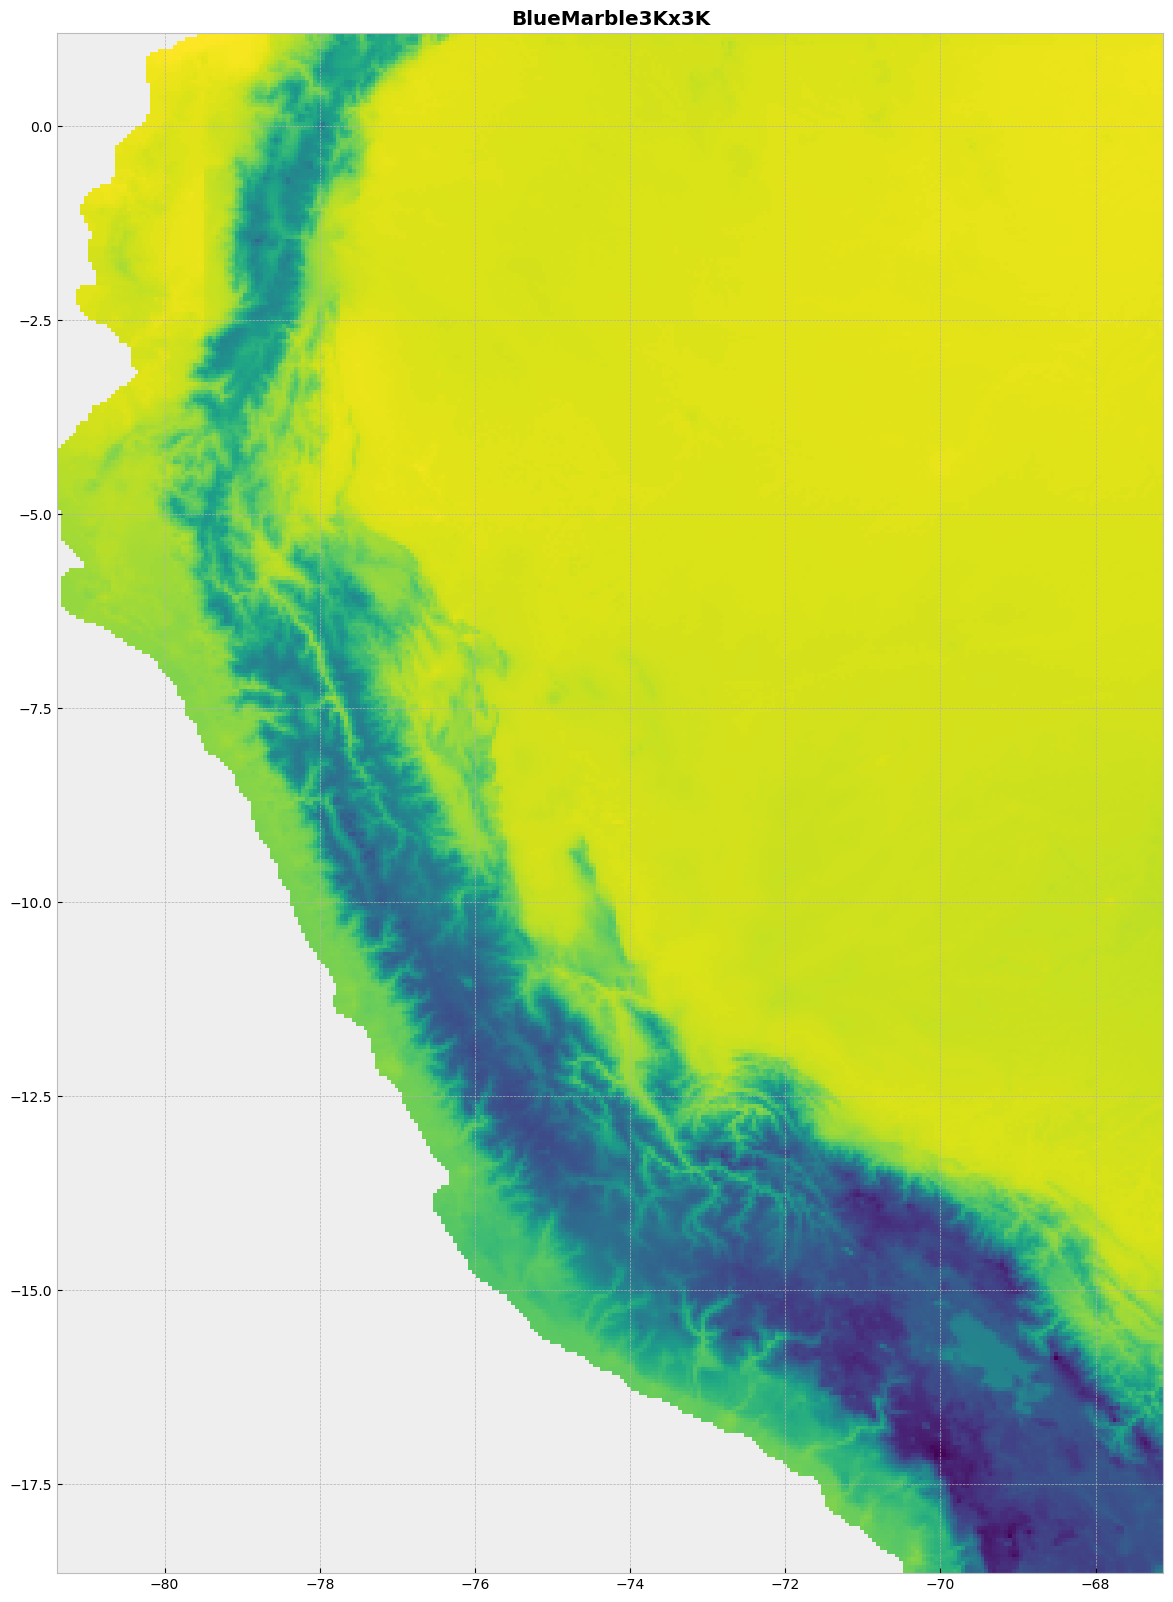

In [58]:
# Gráfico 

with rasterio.open(url) as src:
    fig, ax = plt.subplots(figsize=(20,20))
    show(src, ax=ax, title="BlueMarble3Kx3K", adjust='linear')

## 3.2 Zonal statistics

### 3.2.1. Units: if the raster is scaled (°C × 10), rescale to actual °C.

In [59]:
with rasterio.open(url) as src:
    print("Bands:", src.count)
    print("CRS:", src.crs)
    print("Dtype:", src.dtypes)
    print("NoData vals:", src.nodatavals)

Bands: 5
CRS: EPSG:4326
Dtype: ('float32', 'float32', 'float32', 'float32', 'float32')
NoData vals: (None, None, None, None, None)


In [60]:
with rasterio.open(url) as src:
    arr = src.read(1, masked=False)  # <- sin máscara
    nod = src.nodatavals[0]          # podría ser None
    if nod is not None:
        arr = np.where(arr == nod, np.nan, arr)
    print("Min:", np.nanmin(arr))
    print("Max:", np.nanmax(arr))

Min: -9.052621
Max: 24.636774


Units check; Tmin raster already in °C (no rescaling needed)

### 3.2.2. Minimum metrics: count, mean, min, max, std, percentile_10, percentile_90 (+1 custom).

In [61]:
from rasterstats import zonal_stats
import pandas as pd
import numpy as np

zs = zonal_stats(
    maps,                                   # GeoDataFrame de distritos
    url,                                    # tu GeoTIFF
    stats=['count','mean','min','max','std','percentile_10','percentile_90'],
    nodata=None
)
result = pd.DataFrame(zs)
# métrica personalizada minimalista: bandera de “distrito frío” si mean<0 °C
result['cold_flag'] = (result['mean'] < 0).astype(int)
result.head()


,min,max,mean,count,std,percentile_10,percentile_90,cold_flag
0,8.903979,22.604116,18.932154,107,3.430219,13.836891,22.358987,0
1,19.775057,22.860834,22.290649,57,0.464426,21.992695,22.676195,0
2,21.953405,22.141968,22.056366,6,0.076649,21.955791,22.137794,0
3,21.661476,22.481043,22.263211,62,0.158932,22.042723,22.416751,0
4,21.975763,22.385101,22.173068,22,0.118299,22.023389,22.361992,0


In [62]:
result.sort_values('mean').head(10)

,min,max,mean,count,std,percentile_10,percentile_90,cold_flag
60,-7.490873,-3.204630,-5.241692,37,1.046238,-6.473969,-3.883584,1
56,-8.782926,2.722631,-5.057250,11,3.379965,-8.495632,-0.773760,1
79,-8.722504,-2.467181,-4.926244,88,1.575138,-7.305088,-3.139373,1
49,-6.755064,5.429613,-4.893150,28,2.878483,-6.548187,-3.629575,1
51,-6.302865,2.176187,-4.309868,11,2.738580,-6.163756,0.496034,1
163,-5.922765,-2.714177,-4.249321,52,0.686387,-5.131733,-3.405207,1
61,-8.273415,6.974405,-4.202588,46,3.665782,-6.802698,1.544732,1
525,-4.764343,-2.863132,-4.107042,26,0.521115,-4.724354,-3.356673,1
801,-4.944066,-1.579851,-4.002340,18,0.750202,-4.542455,-3.234743,1
66,-5.608086,-0.829520,-3.418982,33,1.414651,-4.886803,-1.425521,1


In [32]:
# guardar el csv

result.to_csv("tmin_zonalstats.csv", index=False)

### 3.2.3. Territorial level: district (preferred); use province/department if limited by hardware.

In [63]:
# unir las columnas territoriales (UBIGEO, DISTRITO, PROVINCIA, DEPARTAMEN) al resultado
result = pd.concat(
    [maps[['UBIGEO','DISTRITO','PROVINCIA','DEPARTAMEN']].reset_index(drop=True), result],
    axis=1
)

# (opcional) ordenar columnas
result = result[['UBIGEO','DEPARTAMEN','PROVINCIA','DISTRITO',
                 'count','mean','min','max','std','percentile_10','percentile_90','cold_flag']]

result.head()


,UBIGEO,DEPARTAMEN,PROVINCIA,DISTRITO,count,mean,min,max,std,percentile_10,percentile_90,cold_flag
0,100902,HUANUCO,PUERTO INCA,CODO DEL POZUZO,107,18.932154,8.903979,22.604116,3.430219,13.836891,22.358987,0
1,100904,HUANUCO,PUERTO INCA,TOURNAVISTA,57,22.290649,19.775057,22.860834,0.464426,21.992695,22.676195,0
2,250305,UCAYALI,PADRE ABAD,ALEXANDER VON HUMBOLDT,6,22.056366,21.953405,22.141968,0.076649,21.955791,22.137794,0
3,250302,UCAYALI,PADRE ABAD,IRAZOLA,62,22.263211,21.661476,22.481043,0.158932,22.042723,22.416751,0
4,250304,UCAYALI,PADRE ABAD,NESHUYA,22,22.173068,21.975763,22.385101,0.118299,22.023389,22.361992,0


In [64]:
result.to_csv("tmin_zonalstats_territorial.csv", index=False)

## 3.3 Analysis & visualizations

### 3.3.1. Distribution: histogram/KDE of district-level mean Tmin.

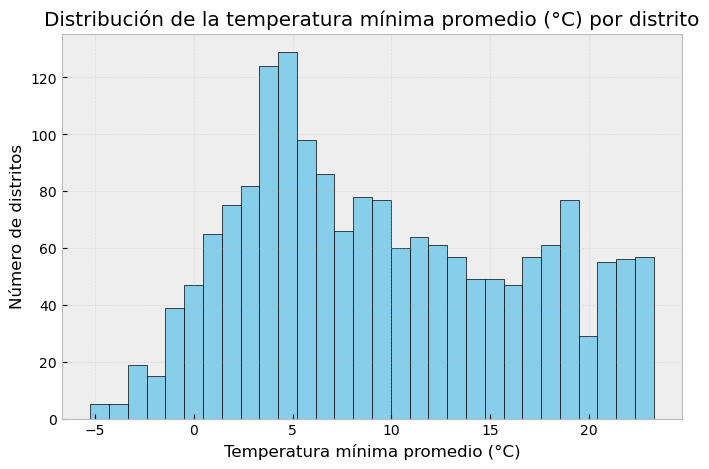

In [65]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))
plt.hist(result['mean'], bins=30, color='skyblue', edgecolor='black')
plt.title('Distribución de la temperatura mínima promedio (°C) por distrito')
plt.xlabel('Temperatura mínima promedio (°C)')
plt.ylabel('Número de distritos')
plt.grid(alpha=0.3)
plt.show()

### 3.3.2. Ranking: Top 15 districts with lowest mean Tmin (frost risk) and top 15 highest.

In [66]:
# Top 15 distritos con menor temperatura mínima promedio
top_cold = result.sort_values('mean', ascending=True).head(15)

# Top 15 distritos con mayor temperatura mínima promedio
top_warm = result.sort_values('mean', ascending=False).head(15)

print("Top 15 coldest districts:")
display(top_cold[['UBIGEO','DEPARTAMEN','PROVINCIA','DISTRITO','mean']])

print("Top 15 warmer districts:")
display(top_warm[['UBIGEO','DEPARTAMEN','PROVINCIA','DISTRITO','mean']])

Top 15 coldest districts:


,UBIGEO,DEPARTAMEN,PROVINCIA,DISTRITO,mean
60,210502,PUNO,EL COLLAO,CAPAZO,-5.241692
56,230406,TACNA,TARATA,SUSAPAYA,-5.057250
79,210504,PUNO,EL COLLAO,SANTA ROSA,-4.926244
49,230401,TACNA,TARATA,TARATA,-4.893150
51,230408,TACNA,TARATA,TICACO,-4.309868
163,040514,AREQUIPA,CAYLLOMA,SAN ANTONIO DE CHUCA,-4.249321
61,230201,TACNA,CANDARAVE,CANDARAVE,-4.202588
525,210707,PUNO,LAMPA,PARATIA,-4.107042
801,080802,CUSCO,ESPINAR,CONDOROMA,-4.002340
66,210405,PUNO,CHUCUITO,PISACOMA,-3.418982


Top 15 warmer districts:


,UBIGEO,DEPARTAMEN,PROVINCIA,DISTRITO,mean
1680,160704,LORETO,DATEM DEL MARAÑON,MORONA,23.294387
1677,160705,LORETO,DATEM DEL MARAÑON,PASTAZA,23.195633
1835,160804,LORETO,PUTUMAYO,YAGUAS,23.131072
1676,160401,LORETO,MARISCAL RAMON CASTILLA,RAMON CASTILLA,23.113361
1675,160404,LORETO,MARISCAL RAMON CASTILLA,SAN PABLO,23.082376
1679,160402,LORETO,MARISCAL RAMON CASTILLA,PEBAS,23.032277
738,160206,LORETO,ALTO AMAZONAS,LAGUNAS,23.007537
1678,160105,LORETO,MAYNAS,LAS AMAZONAS,22.978734
739,160305,LORETO,LORETO,URARINAS,22.955731
680,160801,LORETO,PUTUMAYO,PUTUMAYO,22.944666


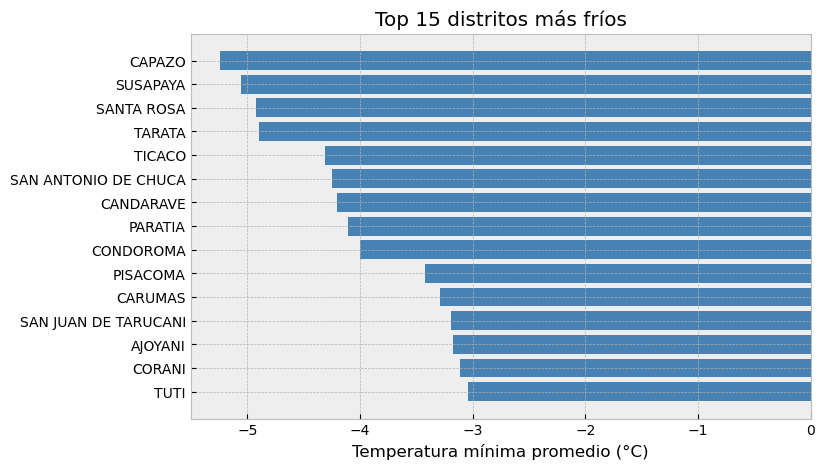

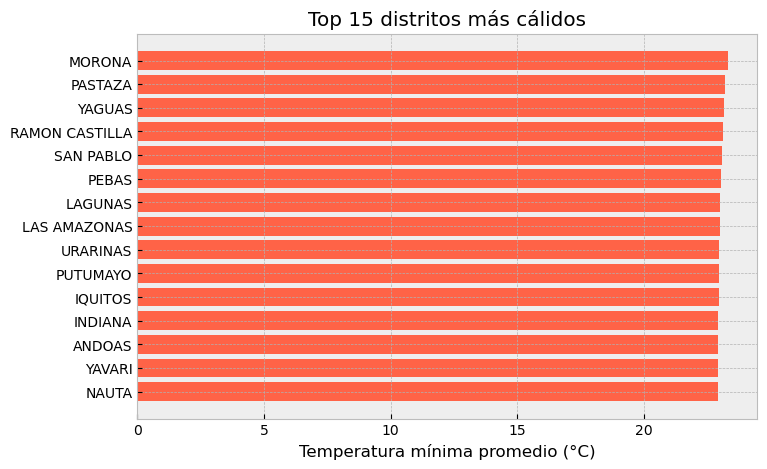

In [53]:
import matplotlib.pyplot as plt

# Gráfico de los 15 más fríos
plt.figure(figsize=(8,5))
plt.barh(top_cold['DISTRITO'], top_cold['mean'], color='steelblue')
plt.xlabel('Temperatura mínima promedio (°C)')
plt.title('Top 15 distritos más fríos')
plt.gca().invert_yaxis()
plt.show()

# Gráfico de los 15 más cálidos
plt.figure(figsize=(8,5))
plt.barh(top_warm['DISTRITO'], top_warm['mean'], color='tomato')
plt.xlabel('Temperatura mínima promedio (°C)')
plt.title('Top 15 distritos más cálidos')
plt.gca().invert_yaxis()
plt.show()

### 3.3.3. Map: static choropleth with GeoPandas; save PNG for the app and provide a downloadable table.

<Figure size 1000x1000 with 0 Axes>

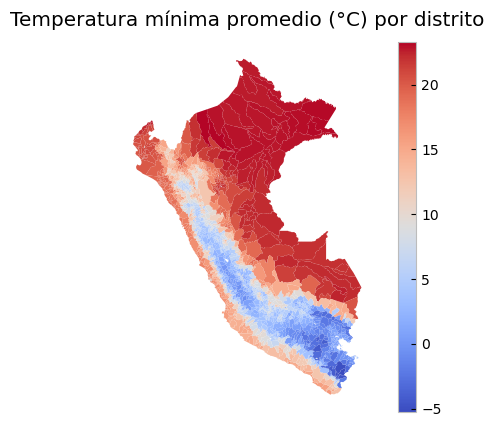

In [67]:
# --- 3.3.3. Static choropleth (GeoPandas) + save PNG & CSV ---

import geopandas as gpd
import matplotlib.pyplot as plt
from pathlib import Path

# Suponemos que ya tienes:
# - maps  -> GeoDataFrame con UBIGEO y geometry (y nombres si quieres)
# - result -> DataFrame con UBIGEO y métricas (incluye 'mean')

# 1) Unir geometría + promedio (solo lo necesario para el mapa)
gmap = maps[['UBIGEO','DEPARTAMEN','PROVINCIA','DISTRITO','geometry']].merge(
    result[['UBIGEO','mean']], on='UBIGEO', how='left'
)

# 2) Crear carpetas de salida para la app
Path('app/assets').mkdir(parents=True, exist_ok=True)
Path('app/data').mkdir(parents=True, exist_ok=True)

# 3) Guardar la tabla (descargable)
cols = ['UBIGEO','DEPARTAMEN','PROVINCIA','DISTRITO','mean','min','max','std','count','percentile_10','percentile_90']
cols = [c for c in cols if c in result.columns]  # por si falta alguna
result[cols].sort_values('mean').to_csv('app/data/tmin_zonalstats_distritos.csv', index=False)

# 4) Mapa coroplético estático (continuo)
plt.figure(figsize=(10, 10))
ax = gmap.plot(
    column='mean',
    cmap='coolwarm',
    legend=True,
    edgecolor='none',
    missing_kwds={'color':'lightgrey','label':'Sin datos'}
)
plt.title('Temperatura mínima promedio (°C) por distrito', pad=12)
plt.axis('off')

# 5) Guardar PNG para la app
plt.savefig('app/assets/map_tmin.png', dpi=200, bbox_inches='tight')
plt.show()


## 3.4 Public policy (guide) -- Text

Focus on high-Andean frost (Puno, Cusco, Ayacucho, Huancavelica, Pasco, etc.) and Amazon cold surges (Loreto, Ucayali, Madre de Dios). For each proposal include:
•	Specific objective (e.g., reduce ILI/ARI, agricultural losses, missed school days).
•	Target population/territory (districts ≤ Tmin p10).
•	Intervention (e.g., thermal housing/ISUR, anti-frost kits, agricultural calendars, livestock shelters).
•	Estimated cost (simple assumptions; S/ per household/school/clinic).
•	KPI (e.g., −X% ARI cases in ESSALUD/MINSA; −X% alpaca mortality; +X% school attendance).


En línea con el análisis desarrollado de las diferencias en temperaturas, se encuentra en base a la evidencia, que las temperaturas más bajas se encuentran en los distritos pertenecientes a la Sierra Sur según como se ilustra en la siguiente imagen:
 

In [ ]:
#plt.show('app/assets/map_tmin.png', dpi=200, bbox_inches='tight')

Filtrando para los 15 distritos más fríos, se encuentra que estos pertenecen principalmente a: Puno
1.	Tacna
2.	Arequipa
3.	Cusco
4.	Moquegua


In [ ]:
display(top_cold[['UBIGEO','DEPARTAMEN','PROVINCIA','DISTRITO','mean']])


En ese sentido, se proponen las siguientes como políticas públicas a implementar desde distintos ámbitos del Sector Público:

 Una propuesta desde el Sector Salud a cargo de MINSA sería la implementación de un "Programa Integral de Prevención y Atención de Neumonía en la Sierra Sur", que incluya:
1.	Fortalecimiento de la infraestructura sanitaria: Mejorar y equipar los centros de salud locales para garantizar atención oportuna y de calidad.
2.	Campañas de sensibilización y educación comunitaria: Informar a la población sobre medidas preventivas, como el uso adecuado de ropa de abrigo y la ventilación de viviendas.
3.	Ampliación de la cobertura de vacunación: Asegurar que niños y adultos mayores reciban las vacunas contra la influenza y el neumococo, con especial énfasis en las zonas rurales.
4.	Monitoreo y vigilancia epidemiológica: Establecer sistemas de alerta temprana para detectar brotes y responder rápidamente.
Dicha estrategia debe ser implementada en colaboración con gobiernos locales, organizaciones comunitarias y las unidades ejecutoras el Ministerio de Salud, adaptándose a las particularidades culturales y geográficas de cada distrito. La inversión en estas medidas fortalecería el sistema de salud en la región, mejorando la calidad de vida de sus habitantes.


Desde el sector Agropecuario, a cargo del Ministerio de Desarrollo Agrario 

El Ministerio de Desarrollo Agrario y Riego (Midagri), a través del programa Agro Rural, tendría que REPOTENCIAR el "Plan Multisectorial ante Heladas y Friaje 2025–2027", con una inversión de S/ 94 millones para beneficiar a más de 54,900 familias productoras en 15 regiones del país: Las acciones a implementar incluyen la entrega de 18,012 kits veterinarios, 3,500 kits de aplicación foliar, 860 kits de conservación de forraje, 18,500 kits de semillas de pastos cultivados, 3,227 cobertizos para ganado y 3,102 fitotoldos para cultivos en zonas altoandinas.

Para fortalecer esta estrategia, se propone la implementación de un "Programa Nacional de Resiliencia Agropecuaria ante el Friaje", que contemple:

1.	Fortalecimiento de infraestructura rural: Construcción y mantenimiento de cobertizos, fitotoldos y sistemas de riego en zonas vulnerables.
2.	Capacitación y asistencia técnica: Entrenamiento en prácticas agrícolas y ganaderas resilientes al clima, incluyendo el uso de cultivos resistentes al frío y manejo adecuado del ganado.
3.	Acceso a financiamiento y seguros agrícolas: Facilitar créditos blandos y seguros que permitan a los productores recuperarse rápidamente tras eventos climáticos extremos.
4.	Monitoreo y alerta temprana: Implementación de sistemas de información climática y redes de alerta para anticipar eventos de friaje y coordinar respuestas oportunas.
